**Đánh giá ảnh hưởng của sự kiện Credit Suisse tại Việt Nam**

*Liệu sự kiện Credit Suisse tại Thụy Sỹ có tác động tiêu cực tới thị trường Việt Nam hay không?*

Hướng tiếp cận: Nghiên cứu Sự kiện để Đánh giá Tác động Tức thời

Phương pháp này sẽ tập trung vào chỉ số VNIndex để xem liệu có "lợi nhuận bất thường" (abnormal returns) trong những ngày diễn ra các sự kiện quan trọng của Credit Suisse hay không.

**Các Sự kiện Chính (Key Events):**

- Sự kiện 1 (Greensill): Credit Suisse đóng băng các quỹ (01/03/2021). 

- Sự kiện 2 (Archegos): Credit Suisse công bố khoản lỗ (06/04/2021).

- Sự kiện 3 (UBS tiếp quản): Công bố vào Chủ Nhật, 19/03/2023. Ngày thị trường phản ứng sẽ là Thứ Hai, 20/03/2023, đây là t=0.

In [1]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from functools import reduce
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Bước 1: Tải và Chuẩn bị Dữ liệu

Thực hiện các bước tiền xử lý dữ liệu cơ bản. Dữ liệu giá đóng cửa hằng ngày của VN-Index và S&P 500 được tải, gộp chung theo ngày giao dịch và làm sạch. Bước quan trọng nhất là chuyển đổi chuỗi giá ($P_t$) thành chuỗi lợi suất logarit ($R_t$) để đảm bảo tính dừng của chuỗi, một yêu cầu quan trọng cho mô hình hồi quy.

Công thức tính lợi suất logarit:

$$
R_t = \ln(P_t) - \ln(P_{t-1}) = \ln \left( \frac{P_t}{P_{t-1}} \right)
$$

In [3]:
# Cell 1: Tải và Chuẩn bị Dữ liệu
import pandas as pd
import numpy as np
from pathlib import Path
from functools import reduce

print("--- Bước 1: Tải và Chuẩn bị Dữ liệu ---")

try:
    notebook_path = Path().resolve()
    base_dir = notebook_path.parent
    market_dir = base_dir / "data" / "silver" / "market_data"

    paths = [
        market_dir / "VNINDEX_1D.csv",
        market_dir / "SP_500_1D.csv"
    ]

    dfs = []
    for p in paths:
        if not p.exists():
            raise FileNotFoundError(
                f"Không tìm thấy file: {p}. Vui lòng kiểm tra lại đường dẫn."
            )

        tmp = pd.read_csv(p, usecols=['time', 'close'])
        new_name = p.stem.replace('_1D', '')  # Tên cột gọn hơn, ví dụ: 'VNINDEX'
        tmp = tmp.rename(columns={'close': new_name})
        tmp['time'] = pd.to_datetime(tmp['time'])
        dfs.append(tmp)

    # Gộp các DataFrame theo cột 'time', giữ lại tất cả các ngày.
    df = reduce(lambda left, right: pd.merge(
        left, right, on='time', how='outer'), dfs)
    df.sort_values('time', inplace=True)

    # Đặt cột 'time' làm chỉ mục (index) của DataFrame.
    df.set_index('time', inplace=True)

    # Điền các giá trị bị thiếu bằng giá trị gần nhất trước đó (forward fill).
    df.fillna(method='ffill', inplace=True)

    # Tính toán lợi suất logarit (log return).
    for col in df.columns:
        df[f'{col}_Return'] = np.log(df[col]).diff()

    # Loại bỏ các hàng có giá trị NaN (thường là hàng đầu tiên sau khi diff()).
    df.dropna(inplace=True)

    print("Dữ liệu đã được tải và xử lý thành công.")
    print(df.head())

except FileNotFoundError as e:
    print(e)
    # Tạo dữ liệu giả để chạy ví dụ nếu không tìm thấy file.
    print("Tạo dữ liệu giả để tiếp tục chạy ví dụ...")
    date_range = pd.date_range(start='2020-01-01', end='2023-12-31', freq='B')
    data = {
        'VNINDEX': 1000 + np.random.randn(len(date_range)).cumsum(),
        'SP_500': 3000 + np.random.randn(len(date_range)).cumsum()
    }
    df = pd.DataFrame(data, index=date_range)
    df['VNINDEX_Return'] = np.log(df['VNINDEX']).diff()
    df['SP_500_Return'] = np.log(df['SP_500']).diff()
    df.dropna(inplace=True)

--- Bước 1: Tải và Chuẩn bị Dữ liệu ---
Dữ liệu đã được tải và xử lý thành công.
            VNINDEX   SP_500  VNINDEX_Return  SP_500_Return
time                                                       
2020-10-02   909.91  3348.44       -0.004583      -0.009618
2020-10-03   909.91  3348.44        0.000000       0.000000
2020-10-04   909.91  3348.44        0.000000       0.000000
2020-10-05   914.68  3408.63        0.005229       0.017816
2020-10-06   915.67  3360.95        0.001082      -0.014087


# Bước 2: Phân tích Sự kiện và Kiểm định Thống kê

Đây là bước chính thực hiện phân tích. Quy trình như sau:

### 1. Mô hình thị trường (Market Model)
Ước tính lợi suất kỳ vọng của VN-Index dựa trên lợi suất của thị trường toàn cầu (S&P 500) trong một "cửa sổ ước tính" (estimation window) trước sự kiện.

$$
R_{vn,t} = \alpha + \beta \cdot R_{sp500,t} + \epsilon_t
$$

---

### 2. Kiểm định Tự tương quan
Áp dụng kiểm định Ljung-Box trên phần dư ($\epsilon_t$) của mô hình.  
Giả thuyết null ($H_0$) là không có tự tương quan.  
Nếu p-value < 0.05, ta bác bỏ $H_0$.

---

### 3. Lợi nhuận Bất thường (AR)
Trong "cửa sổ sự kiện" (event window), tính toán lợi nhuận bất thường bằng cách lấy lợi nhuận thực tế trừ đi lợi nhuận kỳ vọng dự báo từ mô hình:

$$
AR_t = R_{vn,t} - (\hat{\alpha} + \hat{\beta} \cdot R_{sp500,t})
$$

---

### 4. Lợi nhuận Bất thường Tích lũy (CAR)
Tổng AR trong một khoảng thời gian cụ thể, ví dụ từ $t_1$ đến $t_2$:

$$
CAR(t_1, t_2) = \sum_{t=t_1}^{t_2} AR_t
$$

---

### 5. Kiểm định Ý nghĩa Thống kê
Tính toán thống kê T (T-statistic) để xem CAR có khác biệt đáng kể so với 0 hay không.

- **Nếu không có tự tương quan (Ljung-Box p > 0.05):**  
  Sử dụng phương pháp Brown & Warner (1985).  
  Phương sai của CAR được tính bằng:

  $$
  Var(CAR(L)) = L \cdot \hat{\sigma}^2_\epsilon
  $$

  Trong đó $L$ là số ngày trong cửa sổ và $\hat{\sigma}^2_\epsilon$ là phương sai phần dư từ mô hình.

- **Nếu có tự tương quan (Ljung-Box p ≤ 0.05):**  
  Sử dụng phương pháp Newey-West (HAC - Heteroskedasticity and Autocorrelation Consistent) để ước tính phương sai của CAR, giúp kết quả đáng tin cậy hơn.


--- Đang xử lý sự kiện: Greensill (2021-03-01) ---

--- Kiểm định tự tương quan Ljung-Box (lags=10) ---
      lb_stat  lb_pvalue
10  10.825214   0.371297
=> resid: Không bác bỏ H0 (không tìm thấy tự tương quan rõ), p=0.3712966740081269


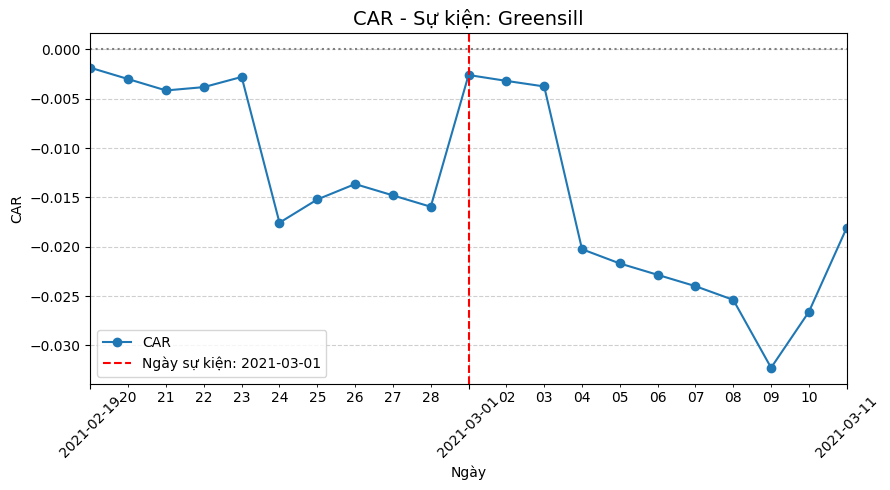


--- Đang xử lý sự kiện: Archegos (2021-04-06) ---

--- Kiểm định tự tương quan Ljung-Box (lags=10) ---
      lb_stat  lb_pvalue
10  13.725879   0.185866
=> resid: Không bác bỏ H0 (không tìm thấy tự tương quan rõ), p=0.18586629149100362


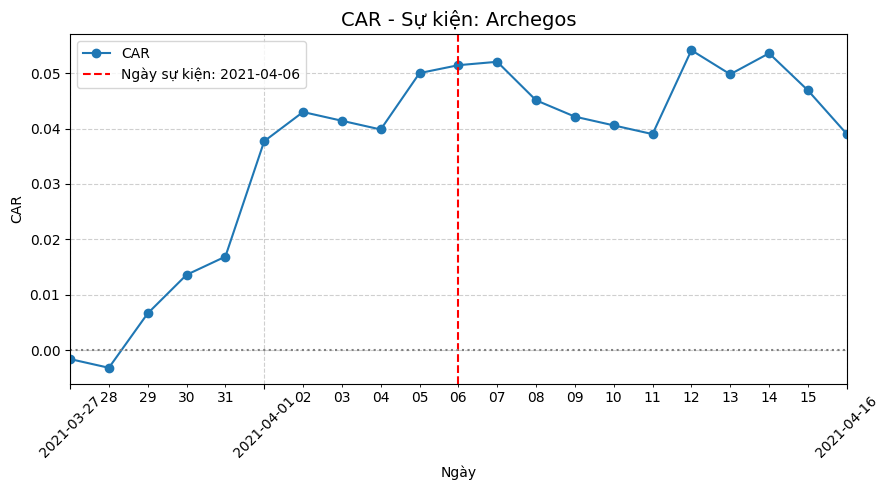


--- Đang xử lý sự kiện: UBS_takeover (2023-03-20) ---

--- Kiểm định tự tương quan Ljung-Box (lags=10) ---
    lb_stat  lb_pvalue
10   2.4654    0.99137
=> resid: Không bác bỏ H0 (không tìm thấy tự tương quan rõ), p=0.9913703816425782


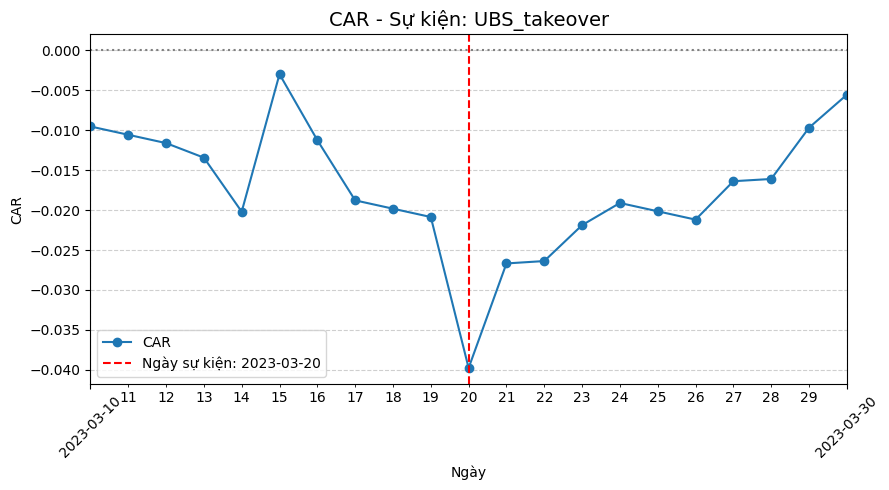

In [4]:
# Cell 2: Phân tích Sự kiện và Kiểm định Thống kê
import statsmodels.api as sm
from testing_models import perform_ljungbox_test
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==============================================================================
# Các hàm trợ giúp (Helper Functions)
# ==============================================================================


def plot_car(series: pd.Series, title: str, event_dt: pd.Timestamp):
    """Vẽ biểu đồ Lợi nhuận Bất thường Tích lũy (CAR)."""
    fig, ax = plt.subplots(figsize=(9, 5))
    series.plot(ax=ax, marker='o', linestyle='-')
    ax.axvline(event_dt, color='red', linestyle='--', label=f'Ngày sự kiện: {event_dt.date()}')
    ax.axhline(0, color='gray', linestyle=':')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Ngày")
    ax.set_ylabel("CAR")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ==============================================================================
# Thiết lập các tham số cho Event Study
# ==============================================================================

# Các ngày sự kiện
event_dates = {
    'Greensill': pd.to_datetime('2021-03-01'),
    'Archegos': pd.to_datetime('2021-04-06'),
    'UBS_takeover': pd.to_datetime('2023-03-20'),
}

# Cấu hình cửa sổ phân tích
ESTIMATION_WINDOW_DAYS = 100  # t=-130 đến t=-31 (220 ngày gd)
GAP_DAYS = 30                 # Khoảng đệm
EVENT_WINDOW_BEFORE = 10      # 10 ngày trước sự kiện
EVENT_WINDOW_AFTER = 10       # 10 ngày sau sự kiện
DEFAULT_HAC_MAXLAGS = 4       # Số lag tối đa cho Newey-West

results_summary = []

# ==============================================================================
# Vòng lặp xử lý chính
# ==============================================================================

for event_name, raw_event_date in event_dates.items():
    print(f"\n{'='*60}\n--- Đang xử lý sự kiện: {event_name} ({raw_event_date.date()}) ---\n{'='*60}")
    try:
        # Tìm ngày giao dịch thực tế tương ứng với ngày sự kiện
        pos = df.index.searchsorted(raw_event_date)
        event_trade_date = df.index[pos]
    except IndexError:
        print('Bỏ qua: Ngày sự kiện nằm ngoài phạm vi dữ liệu.')
        continue

    event_pos = df.index.get_loc(event_trade_date)

    # Xác định các cửa sổ
    estimation_end = event_pos - GAP_DAYS
    estimation_start = estimation_end - ESTIMATION_WINDOW_DAYS
    event_start = event_pos - EVENT_WINDOW_BEFORE
    event_end = event_pos + EVENT_WINDOW_AFTER

    if estimation_start < 0 or event_end >= len(df):
        print('Bỏ qua: Không đủ dữ liệu cho cửa sổ ước tính hoặc cửa sổ sự kiện.')
        continue

    estimation_data = df.iloc[estimation_start:estimation_end + 1]
    event_window_data = df.iloc[event_start:event_end + 1].copy()

    # 1. Chạy mô hình thị trường (OLS) trên cửa sổ ước tính
    X = sm.add_constant(estimation_data['SP_500_Return'])
    y = estimation_data['VNINDEX_Return']
    model = sm.OLS(y, X, missing='drop').fit()

    # 2. Kiểm định tự tương quan trên phần dư
    ljung_results = perform_ljungbox_test(model.resid, lags=10)
    resid_name = model.resid.name if model.resid.name else 'resid'
    p_value = ljung_results.get(resid_name, np.nan)
    has_autocorr = False if np.isnan(p_value) else (p_value <= 0.05)

    # 3. Tính Lợi nhuận bất thường (AR) và CAR
    X_event = sm.add_constant(event_window_data['SP_500_Return'])
    normal_returns = model.predict(X_event)
    event_window_data['AR'] = event_window_data['VNINDEX_Return'] - normal_returns
    event_window_data['CAR'] = event_window_data['AR'].cumsum()

    # 4. Kiểm định ý nghĩa thống kê cho các cửa sổ con
    windows_to_test = [(-1, 1), (-5, 5), (-10, 10)]
    for (t1, t2) in windows_to_test:
        slice_start = event_pos + t1
        slice_end = event_pos + t2
        if slice_start < event_start or slice_end > event_end:
            continue
            
        ar_slice = event_window_data['AR'].iloc[
            (slice_start - event_start):(slice_end - event_start + 1)
        ]
        car_val = ar_slice.sum()
        L_slice = len(ar_slice)

        se_car = np.nan
        if has_autocorr:
            # Cải tiến: Tính phương sai HAC trực tiếp trên lát dữ liệu AR
            if L_slice > 1:
                # Chạy mô hình OLS chỉ có hệ số chặn cho chuỗi AR
                ar_model = sm.OLS(ar_slice, sm.add_constant(np.ones(L_slice))).fit()
                # Lấy phương sai của hệ số chặn đã điều chỉnh HAC
                hac_cov = ar_model.cov_params_HAC(maxlags=DEFAULT_HAC_MAXLAGS)
                var_mean_hac = hac_cov.iloc[0, 0]
                # Phương sai của tổng = L^2 * Phương sai của trung bình
                var_car = (L_slice ** 2) * var_mean_hac
                se_car = np.sqrt(var_car) if var_car >= 0 else np.nan
        else:
            # Dùng phương pháp Brown & Warner tiêu chuẩn
            sigma2_hat = model.mse_resid  # Phương sai của phần dư
            var_car = L_slice * sigma2_hat
            se_car = np.sqrt(var_car)

        # Tính T-statistic và p-value
        if pd.notna(se_car) and se_car > 0:
            t_stat = car_val / se_car
            p_value = stats.t.cdf(t_stat, df=model.df_resid) # Kiểm định 1 phía
        else:
            t_stat = np.nan
            p_value = np.nan

        results_summary.append({
            'Event': event_name,
            'Window': f'[{t1},{t2}]',
            'CAR': car_val,
            'T-stat': t_stat,
            'P-value': p_value,
            'Used_HAC': bool(has_autocorr),
        })

    plot_car(event_window_data['CAR'], f'CAR - Sự kiện: {event_name}', event_trade_date)

# Bước 3: Tổng hợp và Diễn giải Kết quả
Bước cuối cùng này tổng hợp tất cả kết quả từ các sự kiện vào một DataFrame duy nhất để dễ dàng so sánh và báo cáo. Một vòng lặp đơn giản sẽ tự động quét qua kết quả và in ra những diễn giải ngắn gọn cho các trường hợp có tác động tiêu cực và mang ý nghĩa thống kê (p-value ≤ 0.05).

In [5]:
# Cell 3: Tổng hợp và Diễn giải Kết quả
results_df = pd.DataFrame(results_summary)

print("\n" + "="*80)
print("BẢNG TỔNG HỢP KẾT QUẢ PHÂN TÍCH SỰ KIỆN")
print("="*80)

if results_df.empty:
    print('Không có kết quả nào được tạo ra. Vui lòng kiểm tra lại dữ liệu và tham số.')
else:
    # Sử dụng display để hiển thị DataFrame đẹp hơn trong notebook
    display(results_df)

    print("\n" + "-"*80)
    print("DIỄN GIẢI KẾT QUẢ TỰ ĐỘNG:")
    print("-"*80)
    
    significant_results = results_df[
        (results_df['P-value'] <= 0.05) & (results_df['CAR'] < 0)
    ]

    if significant_results.empty:
        print("Không tìm thấy tác động tiêu cực nào có ý nghĩa thống kê (p <= 0.05).")
    else:
        for _, row in significant_results.iterrows():
            print(
                f"-> Sự kiện '{row['Event']}' trong cửa sổ {row['Window']}: "
                f"Ghi nhận tác động TIÊU CỰC có ý nghĩa thống kê.\n"
                f"   (CAR = {row['CAR']:.4f}, p-value = {row['P-value']:.4f}, "
                f"Sử dụng HAC: {row['Used_HAC']})"
            )


BẢNG TỔNG HỢP KẾT QUẢ PHÂN TÍCH SỰ KIỆN


,Event,Window,CAR,T-stat,P-value,Used_HAC
0,Greensill,"[-1,1]",0.011603,0.517577,0.697046,False
1,Greensill,"[-5,5]",-0.020051,-0.467101,0.320727,False
2,Greensill,"[-10,10]",-0.018068,-0.304621,0.380647,False
3,Archegos,"[-1,1]",0.012209,0.477491,0.682967,False
4,Archegos,"[-5,5]",0.022093,0.451233,0.673596,False
5,Archegos,"[-10,10]",0.039022,0.576828,0.717317,False
6,UBS_takeover,"[-1,1]",-0.006850,-0.300801,0.382099,False
7,UBS_takeover,"[-5,5]",0.000049,0.001132,0.500451,False
8,UBS_takeover,"[-10,10]",-0.005569,-0.092427,0.463273,False



--------------------------------------------------------------------------------
DIỄN GIẢI KẾT QUẢ TỰ ĐỘNG:
--------------------------------------------------------------------------------
Không tìm thấy tác động tiêu cực nào có ý nghĩa thống kê (p <= 0.05).


Giả sử thị trường Việt Nam bị ảnh hưởng, nhà đầu tư tại Việt Nam sẽ chịu rủi ro như thế nào?

In [6]:
from var_general_model import var_pipeline
def format_and_print_results(pipeline_output):
    """
    Hàm này nhận output từ var_pipeline và in ra kết quả
    một cách có cấu trúc và dễ đọc.
    """
    if not pipeline_output:
        print("Pipeline không trả về kết quả.")
        return

    # Lấy các kết quả chính từ output
    model_type = pipeline_output.get('model_type', 'Không xác định')
    results = pipeline_output.get('results')
    forecast_df = pipeline_output.get('forecast')
    final_exogs = pipeline_output.get('final_exogs', [])

    print("="*80)
    print(f"               KẾT QUẢ PHÂN TÍCH MÔ HÌNH {model_type.upper()}")
    print("="*80)

    # --- 1. In tóm tắt mô hình ---
    if results:
        print("\n--- 1. TÓM TẮT KẾT QUẢ MÔ HÌNH ---")
        print(f"Mô hình được lựa chọn tự động là: {model_type}")
        print("\nBảng tóm tắt các hệ số và thống kê mô hình:")
        print(results.summary())
    else:
        print("\n--- 1. TÓM TẮT KẾT QUẢ MÔ HÌNH ---")
        print("Không có kết quả mô hình để hiển thị.")

    # --- 2. In bảng dự báo ---
    if forecast_df is not None and not forecast_df.empty:
        print("\n\n--- 2. BẢNG DỰ BÁO CHO CÁC BIẾN NỘI SINH ---")
        print(f"Dưới đây là dự báo cho {len(forecast_df)} bước thời gian tiếp theo:")
        # Sử dụng to_string() để format đẹp hơn trong terminal/notebook
        print(forecast_df.head().to_string())
        if len(forecast_df) > 5:
            print("...")
    else:
        print("\n\n--- 2. BẢNG DỰ BÁO CHO CÁC BIẾN NỘI SINH ---")
        print("Không có dữ liệu dự báo được tạo ra.")

    # --- 3. In danh sách biến ngoại sinh cuối cùng ---
    print("\n\n--- 3. DANH SÁCH BIẾN NGOẠI SINH CUỐI CÙNG ---")
    if final_exogs:
        print("Các biến ngoại sinh được sử dụng trong mô hình sau khi xử lý (PCA, Granger,...):")
        # In 5 biến trên mỗi dòng cho dễ nhìn
        for i in range(0, len(final_exogs), 5):
            print("  - " + ", ".join(final_exogs[i:i+5]))
    else:
        print("Mô hình không sử dụng biến ngoại sinh nào.")
        
    print("\n" + "="*80)

pipeline_output = var_pipeline(data_root = base_dir,VNIndex = True, use_granger_selection= True)


=== Tổng quan biến ===
Endogenous (market, original levels): ['CBOE_Volatility_Index_FRED', 'CDS_5Y_CS_1D', 'PRICE_CS_1D', 'SX7E_STOXX_Banks_EUR_Price', 'VNINDEX_1D']
Candidate exogenous variables: ['Provision for credit losses', 'Non-accrual loans / Gross loans', 'Gross impaired loans / Gross loans', 'Allowance for credit losses / Gross loans', 'Loan-to-Deposit Ratio (LDR)', 'Liquidity Coverage Ratio (LCR)', 'CET1 ratio', 'Tier 1 leverage ratio', 'Cost/income ratio', 'Return on Equity (ROE)', 'ECB_RATE', 'FED_FUNDS', 'ECONOMICS_-USCPI-1D', 'ECONOMICS_CHCPI-1D', 'ECONOMICS_CHGDPCP_1D', 'ECONOMICS_EUCPI-1D', 'ECONOMICS_EUGDPCP_1D', 'ECONOMICS_USGDPCP_1D', 'total_mark']

Dừng: ['Allowance for credit losses / Gross loans', 'CBOE_Volatility_Index_FRED', 'total_mark']

Không dừng: ['Provision for credit losses', 'Non-accrual loans / Gross loans', 'Gross impaired loans / Gross loans', 'Loan-to-Deposit Ratio (LDR)', 'Liquidity Coverage Ratio (LCR)', 'CET1 ratio', 'Tier 1 leverage ratio', 'Co

In [7]:
format_and_print_results(pipeline_output)


               KẾT QUẢ PHÂN TÍCH MÔ HÌNH VECM

--- 1. TÓM TẮT KẾT QUẢ MÔ HÌNH ---
Mô hình được lựa chọn tự động là: VECM

Bảng tóm tắt các hệ số và thống kê mô hình:
   Det. terms outside the coint. relation & lagged endog. parameters for equation CDS_5Y_CS_1D   
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
exog1                            -0.1463      0.744     -0.197      0.844      -1.605       1.312
exog2                            -0.4966      1.068     -0.465      0.642      -2.590       1.597
exog3                            -0.0834      0.574     -0.145      0.884      -1.208       1.041
L1.CDS_5Y_CS_1D                   0.0055      0.030      0.181      0.856      -0.054       0.065
L1.PRICE_CS_1D                    1.0245      7.042      0.145      0.884     -12.777      14.826
L1.SX7E_STOXX_Banks_EUR_Price     2.3409      0.88